# 1.建立一個有簡單短期記憶的聊天機器人

<img src="https://drive.google.com/uc?export=view&id=1Xe-WwHsVBzO6kt0A9TEbYR871coqF03d" width="100"/>

流程：使用者問題(Start) ⭢ 聊天機器人回應(chatbot) ⭢ 回應送給使用者(End)
- 在chatbot的node中，會將聊天記錄存到State中


名詞解釋：
- thread: 同一個對話串為一個thread

In [1]:
%%capture --no-stderr
!pip install -U langgraph langchain transformers bitsandbytes langchain-huggingface langchain_openai==0.3.15

In [16]:
!pip install langchain-community langchain-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.2 MB/s eta 0:00:00


### load local 模型

In [2]:
%%capture --no-stderr
# 使用local模型，會需要一點時間
# 使用local模型，記得將runtime調到T4 GPU (runtime -> change runtime type)
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from langchain_huggingface import HuggingFacePipeline

# 使用 4-bit 量化模型
model_id = "MediaTek-Research/Breeze-7B-Instruct-v1_0"

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    llm_int8_threshold=6.0,
)

# 載入 tokenizer 與 4-bit 模型
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=quant_config,
    trust_remote_code=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
# 建立 text generation pipeline
generator = pipeline(
    task="text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    do_sample=True,
    temperature=0.4,
    return_full_text=False # 僅返回生成的回應內容
)

# 包裝成 LangChain 的 llm 物件
llm_local = HuggingFacePipeline(pipeline=generator)

Device set to use cuda:0


### 使用api (huggingface or openai)

In [4]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')


SecretNotFoundError: Secret OPENAI_API_KEY does not exist.

In [17]:
import os
from langchain.chat_models import AzureChatOpenAI
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace

# 課金openai
llm_api = AzureChatOpenAI(
    openai_api_base="https://intern-bryan.cognitiveservices.azure.com/",
    openai_api_version="2024-08-01-preview",
    deployment_name="gpt-4o",
    openai_api_key="AwKyfa7qPtoM0f9tnZksQSlVKobqzrwVI56Fmbqpv0tU07MM2WV8JQQJ99AKACYeBjFXJ3w3AAAAACOG55vD",
    temperature=0.3,
)

# 呼叫huggingface上的API模型 (free)
llm_endpoint = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen2.5-32B-Instruct",
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)

llm_huggingface = ChatHuggingFace(llm=llm_endpoint, verbose=False)

<ipython-input-17-2eedd29b2b91>:6: LangChainDeprecationWarning: The class `AzureChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import AzureChatOpenAI``.
  llm_api = AzureChatOpenAI(
/usr/local/lib/python3.11/dist-packages/langchain_community/chat_models/azure_openai.py:174: UserWarning: As of openai>=1.0.0, Azure endpoints should be specified via the `azure_endpoint` param not `openai_api_base` (or alias `base_url`). Updating `openai_api_base` from https://intern-bryan.cognitiveservices.azure.com/ to https://intern-bryan.cognitiveservices.azure.com/openai.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/langchain_community/chat_models/azure_openai.py:181: UserWarning: As of openai>=1.0.0, if `deployment_name` (or alias `azure_deployment`) is 

### 建立一個有狀態的圖(StateGraph)


In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import convert_to_openai_messages, SystemMessage, HumanMessage, AIMessage, BaseMessage
from langchain_core.runnables.config import RunnableConfig

from langgraph.checkpoint.memory import MemorySaver

class State(TypedDict):
  """
  若只有messages, 其實等同於MessageState
  這邊保留彈性
  """
  messages: Annotated[list, add_messages]

def chatbot(state: State, config: RunnableConfig):
  """
  主要處理chatbot回應的邏輯
  這裡僅單純將使用者的對話紀錄(傳入的state中的messages)，送入模型產生回應
  """

  system_prompt = "你是 那你還記得我喜歡甚麼嗎個只能使用繁體中文回答的助理"
  mode = config["configurable"]["mode"] # 決定要使用哪個模型

  if mode == "local":
    messages = convert_to_openai_messages(state["messages"]) # Convert LangChain messages into OpenAI message dicts.
    system_message =  [{"role": "system", "content": system_prompt}]
    # apply tokenizer prompt template
    prompt = tokenizer.apply_chat_template(
        system_message+messages,
        tokenize=False,
        add_generation_prompt=True
    )
    response = llm_local.invoke(prompt)
    return {"messages": [AIMessage(content=response)]}
  else:
    system_message = [SystemMessage(content=system_prompt)]
    messages = state["messages"]
    if mode == "openai_api":
      response = llm_api.invoke(system_message+messages)
    elif mode == "huggingface":
      response = llm_huggingface.invoke(system_message+messages)
    return {"messages": [response]}


# 建立一個有StateGraph
graph_builder = StateGraph(State)
#                     node name, 呼叫node時要觸發的邏輯(function or object)
graph_builder.add_node("chatbot", chatbot) # 在graph裡面加入chatbot的node
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# 加入記憶性
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

### Messages補充：

langchain/langgraph messages:
```
[SystemMessage(content="你是個只能使用繁體中文回答的助理"),
 HumanMessage(content='hi'),
 AIMessage(content='你好，我可以幫上什麼忙嗎'),
 HumanMessage(content='hihi')]
```

Hugging Face
```
[{"role": "system", "content": "你是個只能使用繁體中文回答的助理"},
{"role": "user", "content": "hi"},
{"role": "assistant", "content": "你好，我可以幫上什麼忙嗎"},
{"role": "user", "content": "你好"},]

```

Mediatek prompt: (tokenizer.chat_template)
```
<s> 你是個只能使用繁體中文回答的助理。  [INST] hi [/INST] 你好！如果你有任何問題或需要幫助，請不要猶豫，隨時告訴我。 [INST] 你好 [/INST]

```

其他模型prompt template：

```
"""<|im_start|>user
Hi there!<|im_end|>
<|im_start|>assistant
Nice to meet you!<|im_end|>
<|im_start|>user
Can I ask a question?<|im_end|>
"""
```

In [5]:
tokenizer.chat_template

"{% if not add_generation_prompt is defined %}{% set add_generation_prompt = false %}{% endif %}{% if messages[0]['role'] == 'system' %}{% set loop_messages = messages[1:] %}{% set system_message = messages[0]['content'].strip() %}{% else %}{% set loop_messages = messages %}{% set system_message = 'You are a helpful AI assistant built by MediaTek Research. The user you are helping speaks Traditional Chinese and comes from Taiwan.' %}{% endif %}{{ bos_token }} {{ system_message }} {% for message in loop_messages %}{% if (message['role'] == 'user') != (loop.index0 % 2 == 0) %}{{ raise_exception('Conversation roles must alternate user/assistant/user/assistant/... or system/user/assistant/user/assistant/...') }}{% endif %}{% if message['role'] == 'user' %}{{ ' [INST] ' + message['content'] + ' [/INST] ' }}{% elif message['role'] == 'assistant' %}{{ message['content'] }}{% else %}{{ raise_exception('Only user and assistant roles are supported!') }}{% endif %}{% endfor %}"

In [6]:
out = tokenizer.apply_chat_template(
    conversation=[
        {"role": "system", "content": "A system prompt"},
        {"role": "user", "content": "Hi there!"},
        {"role": "assistant", "content": "Nice to meet you!"},
        {"role": "user", "content": "Can I ask a question?"}
    ],
    tokenize=False,
    add_generation_prompt=True
)
print(out)

<s> A system prompt  [INST] Hi there! [/INST] Nice to meet you! [INST] Can I ask a question? [/INST] 


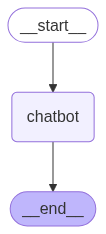

In [7]:
from IPython.display import Image, display

try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)
  pass

In [8]:
def stream_graph_updates(user_input: str, config: dict):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config):
        if "chatbot" in event:
          for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [18]:
# 第一次對話 (thread_id: conversation_1)
mode = "openai_api"
config_1 = {"configurable": {"thread_id": "conversation_1", "mode": mode}} # thread_id: 對話id


while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config_1)
  except Exception as e:
    print(e)
    break

User: 嗨 我是火影忍者迷
Assistant: 嗨！我记得你是火影忍者迷。火影忍者有很多精彩的情节和角色，不知道你最喜欢哪一部分或者哪个角色呢？如果有任何想讨论的内容，请随时告诉我！
User: 我喜歡宇智波佐助
Assistant: 宇智波佐助是一个非常受欢迎的角色，他的故事充满了复杂的情感和成长历程。佐助从小经历了家族的悲剧，这使他一开始充满了复仇的欲望，但随着故事的发展，他逐渐找到了自己的道路。他的能力非常强大，尤其是写轮眼和后来的轮回眼，这让他在战斗中无比出色。你喜欢佐助的哪一方面呢？是他的能力、性格，还是他的成长故事？
User: 我們來聊點別的
Assistant: 好的！如果有其他您感兴趣的话题或问题，请随时告诉我。无论是关于其他动漫、电影、书籍，还是任何您想讨论的主题，我都会很乐意与您交流。
User:  那你還記得我喜歡甚麼嗎
Assistant: 我记得你喜欢火影忍者中的宇智波佐助。如果有其他你感兴趣的话题或想要讨论的内容，请随时告诉我！
User: q
Goodbye!


In [19]:
# 看state
graph.get_state(config_1)

StateSnapshot(values={'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='16813b19-57a3-4c3f-9811-c5274229fe81'), AIMessage(content='你好！很高兴能帮助你。如果你有任何问题，请随时提出，我会尽力帮助你解决。', additional_kwargs={}, response_metadata={}, id='859e51af-488f-4882-ad1b-01fd23f56c20'), HumanMessage(content='嗨 我是火影忍者迷', additional_kwargs={}, response_metadata={}, id='7c37f34e-aa2f-4c3f-9700-fbcbdd69cf64'), AIMessage(content='嗨！很高兴能与一个火影忍者迷交流。火影忍者（Naruto）是一部日本的漫畫和动画作品，创作人是岸本桜，故事发生在一个有忍者的世界，主要讲述了火影忍者（火影是忍者之首）的故事。如果你有任何与火影忍者相关的问题，请随时提出，我会尽力帮助你解决。', additional_kwargs={}, response_metadata={}, id='b0f8261b-8f81-4eab-8223-31e9488474be'), HumanMessage(content='我喜歡宇智波佐助', additional_kwargs={}, response_metadata={}, id='8928fd10-aeed-4955-851d-6318ff673eaf'), AIMessage(content='宇智波佐助是火影忍者世界中的一个重要角色，他属于宇智波一族，是一名强大的忍者。他在故事中经历了很多事件，从最初的孤独和憤怒到最后的成长和理解。佐助的能力是掷地为尘（地之阴谋），可以在短时间内迅速移动，以及使用渗透阴谋，这种阴谋可以控制其他人的行動。他与渐变的性格和情绪表达使他成为了一个复杂而有吸引力的角色。如果你有关于宇智波佐助的任何问题，请随时提出，我会尽力帮助你解决。', additional_kwargs={}, 

In [20]:
# 易讀版
def state_pretty_print(state: State):
  for m in state.values["messages"]:
    m.pretty_print()

In [21]:
state_pretty_print(graph.get_state(config_1))

================================ Human Message =================================

Hi
================================== Ai Message ==================================

你好！很高兴能帮助你。如果你有任何问题，请随时提出，我会尽力帮助你解决。
================================ Human Message =================================

嗨 我是火影忍者迷
================================== Ai Message ==================================

嗨！很高兴能与一个火影忍者迷交流。火影忍者（Naruto）是一部日本的漫畫和动画作品，创作人是岸本桜，故事发生在一个有忍者的世界，主要讲述了火影忍者（火影是忍者之首）的故事。如果你有任何与火影忍者相关的问题，请随时提出，我会尽力帮助你解决。
================================ Human Message =================================

我喜歡宇智波佐助
================================== Ai Message ==================================

宇智波佐助是火影忍者世界中的一个重要角色，他属于宇智波一族，是一名强大的忍者。他在故事中经历了很多事件，从最初的孤独和憤怒到最后的成长和理解。佐助的能力是掷地为尘（地之阴谋），可以在短时间内迅速移动，以及使用渗透阴谋，这种阴谋可以控制其他人的行動。他与渐变的性格和情绪表达使他成为了一个复杂而有吸引力的角色。如果你有关于宇智波佐助的任何问题，请随时提出，我会尽力帮助你解决。
================================ Human Message =================================

我們來聊點別的
================================== Ai Message ====

In [22]:
## 第二次對話
mode = "openai_api"
config_2 = {"configurable": {"thread_id": "conversation_2", "mode": mode}} # thread_id: 對話id

while True:
  try:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
      print("Goodbye!")
      break
    stream_graph_updates(user_input, config_2)
  except Exception as e:
    print(e)
    break

User: 你還記得我喜歡甚麼嗎
Assistant: 抱歉，我無法記住個別使用者的個人資訊或喜好。如果你有任何問題或需要幫助，請隨時告訴我！
User: q
Goodbye!


In [23]:
state_pretty_print(graph.get_state(config_2))

================================ Human Message =================================

你還記得我喜歡甚麼嗎
================================== Ai Message ==================================

抱歉，我無法記住個別使用者的個人資訊或喜好。如果你有任何問題或需要幫助，請隨時告訴我！


# 2.Langgraph中的InMemoryStore介紹

組成：
- namespace：物件的命名空間，類似於目錄（資料夾），是一個元組（tuple）
- key：物件的鍵，類似於檔案名稱
- value：物件的值，類似於檔案內容

方法：
- put: 將欲放入的key-value放到指定的namespace
- search: 找尋指定的namespace
- get: 從指定的namespace, 找到指定key中的值

In [24]:
from langgraph.store.memory import InMemoryStore
in_memory_store = InMemoryStore()

In [25]:
## 寫入長期記憶

# Save the memory   #
in_memory_store.put(namespace=("user_1", "memories"), key="profile", value={"name": "Amy", "gender": "f", "age": 22})
in_memory_store.put(namespace=("user_1", "memories"), key="interests", value=["kendo", "hiking", "reading"])
in_memory_store.put(namespace=("user_2", "memories"), key="profile", value={"name": "Boris", "gender": "m", "age":30 })
in_memory_store.put(namespace=("user_2", "memories"), key="interests", value=["coding", "sleeping"])


In [26]:
# search
# 從namesapce抓取長期記憶
memories = in_memory_store.search(("user_1", "memories"))
print("type of memories: ",type(memories))
print(memories)

type of memories:  <class 'list'>
[Item(namespace=['user_1', 'memories'], key='profile', value={'name': 'Amy', 'gender': 'f', 'age': 22}, created_at='2025-06-02T12:24:09.823648+00:00', updated_at='2025-06-02T12:24:09.823651+00:00', score=None), Item(namespace=['user_1', 'memories'], key='interests', value=['kendo', 'hiking', 'reading'], created_at='2025-06-02T12:24:09.823717+00:00', updated_at='2025-06-02T12:24:09.823718+00:00', score=None)]


In [27]:
memories = in_memory_store.search(("user_2", "memories"))
print(memories)

[Item(namespace=['user_2', 'memories'], key='profile', value={'name': 'Boris', 'gender': 'm', 'age': 30}, created_at='2025-06-02T12:24:09.823769+00:00', updated_at='2025-06-02T12:24:09.823770+00:00', score=None), Item(namespace=['user_2', 'memories'], key='interests', value=['coding', 'sleeping'], created_at='2025-06-02T12:24:09.823818+00:00', updated_at='2025-06-02T12:24:09.823819+00:00', score=None)]


In [28]:
# get
# 從namesapce + key抓取特定長期記憶
memory = in_memory_store.get(("user_1", "memories"), "profile")
memory.value

{'name': 'Amy', 'gender': 'f', 'age': 22}

In [29]:
memory = in_memory_store.get(("user_1", "memories"), "interests")
memory.value

['kendo', 'hiking', 'reading']